# How to Analyze CANN Model?

**Goal**: By the end of this guide, you'll be able to visualize CANN dynamics using energy landscape plots.

**Estimated Reading Time**: 12 minutes

---

## Introduction

After running a CANN simulation, you need to **visualize** the results to understand the network's behavior. Did the bump form correctly? Is it tracking the stimulus? Is the activity stable?

The **Analyzer** module provides visualization tools specifically designed for CANN dynamics. This guide focuses on the most essential visualization: **energy landscape plots**.

You'll learn to:
1. Create static energy landscape plots
2. Generate animated visualizations
3. Compare different models (CANN vs. CANN with SFA)
4. Use the PlotConfig system for consistent styling

## What is an Energy Landscape?

An **energy landscape** shows how neural activity evolves over time:
- **X-axis**: Neuron position (for 1D CANNs, this is angular position from -π to π)
- **Y-axis**: Neural activity or synaptic input
- **Animation**: Time evolution of the activity pattern

This visualization is perfect for observing:
- **Bump formation**: Does a localized activity bump emerge?
- **Tracking**: Does the bump follow external stimuli?
- **Stability**: Does the bump maintain its shape and position?

## The PlotConfig System

Before diving into examples, understand the visualization architecture.

The library uses **PlotConfig** dataclasses to manage plot settings. This provides:
- **Consistency**: Same parameters across different plot types
- **Reusability**: Save and reuse configurations
- **Type safety**: Clear parameter names and validation

In [1]:
from canns.analyzer.plotting import PlotConfigs

# Create a configuration for animation
config = PlotConfigs.energy_landscape_1d_animation(
    time_steps_per_second=100,  # Simulation speed (100 steps/sec)
    fps=20,                     # Animation frame rate
    title='My CANN Simulation',
    xlabel='Position (rad)',
    ylabel='Activity',
    save_path='output.gif',
    show=False                  # Don't display, just save
)

**Why PlotConfig?** Instead of passing 10+ arguments to a function, you configure once and reuse. This becomes especially valuable when creating multiple similar plots.

## Complete Workflow: From Model to Visualization

Let's build a full example that creates, simulates, and visualizes a CANN:

In [ ]:
import brainpy.math as bm
from canns.models.basic import CANN1D
from canns.task.tracking import SmoothTracking1D
from canns.analyzer.plotting import PlotConfigs, energy_landscape_1d_animation

# 1. Setup
bm.set_dt(0.1)

# 2. Create model (auto-initializes)
cann = CANN1D(num=512)

# 3. Create task
task = SmoothTracking1D(
    cann_instance=cann,
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0, 10.0, 10.0, 10.0),
    time_step=bm.get_dt(),
)
task.get_data()

# 4. Run simulation
def run_step(t, inputs):
    cann(inputs)
    return cann.u.value, cann.r.value

us, rs = bm.for_loop(
    run_step,
    operands=(task.run_steps, task.data),
    progress_bar=10
)

print("Simulation complete! Now visualizing...")

# 5. Create visualization config
config = PlotConfigs.energy_landscape_1d_animation(
    time_steps_per_second=100,
    fps=20,
    title='CANN1D Smooth Tracking',
    xlabel='Position (rad)',
    ylabel='Activity',
    repeat=True,
    show=True,
)

# 6. Generate animation
energy_landscape_1d_animation(
    data_sets={
        'u': (cann.x, us),      # Synaptic input over time
        'Iext': (cann.x, task.data)  # External stimulus
    },
    config=config
)

**What's happening in step 6**:
- `data_sets`: Dictionary mapping labels to `(positions, data)` tuples
- `cann.x`: Neuron positions (x-axis values)
- `us`: Activity over time (shape `[time_steps, num_neurons]`)
- `task.data`: Original input stimuli for comparison

The animation will show two curves:
- **Blue (u)**: The CANN's internal activity
- **Orange (Iext)**: The external input stimulus

You'll see the activity bump tracking the moving stimulus!

## Static Plots for Quick Inspection

For quick checks without generating full animations:

Plot saved to: snapshot_t200.png


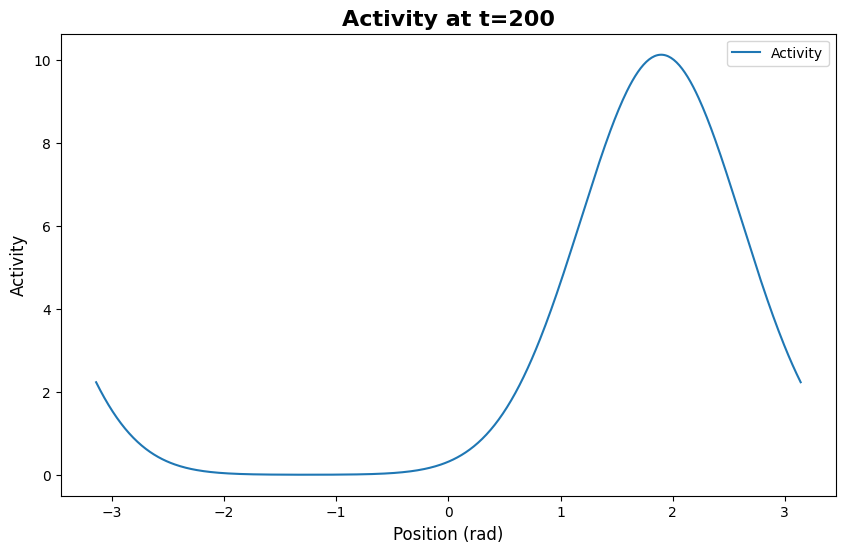

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Activity at t=200'}, xlabel='Position (rad)', ylabel='Activity'>)

In [4]:
from canns.analyzer.plotting import PlotConfigs, energy_landscape_1d_static

# Configuration for static plot
config_static = PlotConfigs.energy_landscape_1d_static(
    time_steps_per_second=100,
    title='Activity at t=200',
    xlabel='Position (rad)',
    ylabel='Activity',
    save_path='snapshot_t200.png',
    show=True  # Display the plot
)

# Plot activity at specific time step (e.g., t=200)
energy_landscape_1d_static(
    data_sets={'Activity': (cann.x, us[200])},  # Single time step
    config=config_static
)

**Use case**: Quickly check if the model reached a stable state at a particular time.

## Comparing Models: CANN vs. CANN-SFA

One powerful visualization technique is **comparing different models side-by-side**. Let's compare a standard CANN with a CANN that includes **Spike Frequency Adaptation (SFA)**:

In [ ]:
import brainpy.math as bm
from canns.models.basic import CANN1D, CANN1D_SFA
from canns.task.tracking import SmoothTracking1D
from canns.analyzer.plotting import PlotConfigs, energy_landscape_1d_animation

bm.set_dt(0.1)

# Create two models (auto-initialize)
cann_standard = CANN1D(num=512)
cann_sfa = CANN1D_SFA(num=512, tau_v=50.0)  # SFA with adaptation time constant

# Same task for both
task = SmoothTracking1D(
    cann_instance=cann_standard,  # Use one model as reference
    Iext=(1.0, 0.75, 2.0, 1.75, 3.0),
    duration=(10.0, 10.0, 10.0, 10.0),
    time_step=0.1,
)
task.get_data()

# Simulate standard CANN
def step_standard(t, inputs):
    cann_standard(inputs)
    return cann_standard.u.value

us_standard = bm.for_loop(
    step_standard,
    operands=(task.run_steps, task.data),
    progress_bar=10
)

# Simulate CANN-SFA
def step_sfa(t, inputs):
    cann_sfa(inputs)
    return cann_sfa.u.value

# Re-initialize for fair comparison
cann_sfa.init_state()
us_sfa = bm.for_loop(
    step_sfa,
    operands=(task.run_steps, task.data),
    progress_bar=10
)

# Visualize both in one animation
config_comparison = PlotConfigs.energy_landscape_1d_animation(
    time_steps_per_second=100,
    fps=20,
    title='CANN vs CANN-SFA: Oscillatory Tracking',
    xlabel='Position (rad)',
    ylabel='Activity',
    repeat=True,
    show=True,
)

energy_landscape_1d_animation(
    data_sets={
        'CANN (Standard)': (cann_standard.x, us_standard),
        'CANN-SFA': (cann_sfa.x, us_sfa),
        'Input': (cann_standard.x, task.data)
    },
    config=config_comparison
)

**What you'll observe**:
- **Standard CANN**: Bump follows input closely
- **CANN-SFA**: Bump may show oscillatory behavior or delayed tracking due to adaptation
- **Insight**: SFA introduces history-dependent dynamics, visible as different tracking patterns

This comparison helps you understand how model variants behave differently under the same conditions.

## Customizing Visualizations

### Adjusting Animation Speed

In [ ]:
config_slow = PlotConfigs.energy_landscape_1d_animation(
    time_steps_per_second=50,   # Show 50 steps per second (slower)
    fps=10,                     # 10 frames per second (smoother)
    ...
)

**Rule of thumb**: `time_steps_per_second / fps` = steps per frame
- Higher ratio = faster animation
- Lower ratio = slower, more detailed animation

### Changing Appearance

In [ ]:
config_styled = PlotConfigs.energy_landscape_1d_animation(
    figsize=(10, 4),            # Wider figure
    title='Custom Styled Plot',
    xlabel='Angular Position',
    ylabel='Firing Rate (Hz)',
    title_fontsize=14,
    save_path='styled_output.gif',
    show=False
)

### Saving vs. Displaying

In [ ]:
# Save only (for batch processing)
config_save = PlotConfigs.energy_landscape_1d_animation(
    save_path='output.gif',
    show=False
)

# Display only (for interactive exploration)
config_display = PlotConfigs.energy_landscape_1d_animation(
    save_path=None,
    show=True
)

# Both
config_both = PlotConfigs.energy_landscape_1d_animation(
    save_path='output.gif',
    show=True
)

## More Analysis Tools

This guide focuses on energy landscapes, but the analyzer module includes many other tools:

- **Tuning curves**: Neuron selectivity plots
- **Firing fields**: Spatial response maps
- **Bump fitting**: Extract bump position and width
- **Spike plots**: Raster plots for spike-based models

These are covered in detail in the [Full Details: Model Analyzer](link-to-full-details) section.

## Next Steps

Now that you can visualize CANN dynamics, you're ready to:

1. **[Analyze experimental data](05_how_to_analyze_experimental_data.md)** - Apply similar techniques to real neural recordings
2. **[Explore Model Analyzer](link-to-core-concepts-analyzer)** - Learn about all available analysis methods
3. **[Full Visualization API](link-to-full-details-analyzer)** - Complete reference for PlotConfig and all plot functions


---

*Questions? Check the [PlotConfig Guide](link-to-plotconfig-detail) or [GitHub Discussions](https://github.com/routhleck/canns/discussions).*